In [1]:
import os, sys
import pandas as pd
import zipfile as zf
import requests

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import cluster
from sklearn.metrics import confusion_matrix
import urllib
import itertools
import pylab as pl
import seaborn as sns

from __future__ import division

% pylab inline

Populating the interactive namespace from numpy and matplotlib


# Data download and move to data directory

In [3]:
try:
    df_2010 = pd.read_csv('Data\\CollegeScorecard_Raw_Data\\MERGED2010_11_PP.csv')

except: 

    url = 'https://ed-public-download.apps.cloud.gov/downloads/CollegeScorecard_Raw_Data.zip'
    file_name = url.split('/')[-1]
    r = requests.get(url)
    with open(file_name, "wb") as code:
        code.write(r.content)
    zipref = zf.ZipFile(file_name, 'r')
    zipref.extractall('Data')
    zipref.close()
    df_2010 = pd.read_csv('Data\\CollegeScorecard_Raw_Data\\MERGED2010_11_PP.csv')

C:\Users\shibbie\Anaconda_2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1,6,1461,1561,1729) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_2010.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,NaN,0.000000,1198.0,NaN,NaN,1,0.4771,0.5229,NaN,1515.0
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,NaN,0.291016,1536.0,NaN,NaN,1,0.4170,0.5830,NaN,2842.0
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,...,NaN,0.000000,13.0,NaN,NaN,1,0.4649,0.5351,NaN,316.0
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,...,NaN,0.336907,653.0,NaN,NaN,1,0.5297,0.4703,NaN,1085.0
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,NaN,NaN,NaN,...,NaN,0.000000,1138.0,NaN,NaN,1,0.4097,0.5903,NaN,2054.0


# What to classify: 

Institution Type by Debt and wages? 


## Control 

1: Public

2: Private Non-Profit

3: Private For-Profit



## REGION 
0	U.S. Service Schools

1	New England (CT, ME, MA, NH, RI, VT)

2	Mid East (DE, DC, MD, NJ, NY, PA)

3	Great Lakes (IL, IN, MI, OH, WI)

4	Plains (IA, KS, MN, MO, NE, ND, SD)

5	Southeast (AL, AR, FL, GA, KY, LA, MS, NC, SC, TN, VA, WV)

6	Southwest (AZ, NM, OK, TX)

7	Rocky Mountains (CO, ID, MT, UT, WY)

8	Far West (AK, CA, HI, NV, OR, WA)

9	Outlying Areas (AS, FM, GU, MH, MP, PR, PW, VI)


## Limit to 4 year universities: ICLEVEL = 1

## Debt variables: 

Median debt for grads: GRAD_DEBT_MDN

Median debt for those who withdraw: WDRAW_DEBT_MDN

Median debt by monthly payment (10 year plan): GRAD_DEBT_MDN10YR

Median debt by fam income

Low (0-30000): LO_INC_DEBT_MDN

Med (30001-75,000): MD_INC_DEBT_MDN

High (>75,000): HI_INC_DEBT_MDN

## Mean & mean earnings of working graduates 6 years after entry

MN_EARN_WNE_P6

MD_EARN_WNE_P6

## Three year repayment rate: 

COMPL_RPY_3YR_RT_SUPP (students who complete)

NONCOM_RPY_3YR_RT_SUPP (sudents who didn't)

## Cohort Default Rate (2 & 3 years): 
CDR2

CDR3

## Share of students w/ any loan
LOAN_EVER

In [6]:
df_4yr_2010 = df_2010[df_2010.ICLEVEL == 1]

In [7]:
variables = ['CONTROL', 'REGION', 'GRAD_DEBT_MDN', 'WDRAW_DEBT_MDN', 'GRAD_DEBT_MDN10YR', 'MN_EARN_WNE_P7', 'COMPL_RPY_3YR_RT_SUPP', 
            'NONCOM_RPY_3YR_RT_SUPP']

In [8]:
reduced = df_4yr_2010[variables]

In [156]:
reduced = reduced.convert_objects(convert_numeric = 'coerce')
reduced.dropna(inplace = True)

C:\Users\shibbie\Anaconda_2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [157]:
reduced.shape

(2249, 8)

# Predict whether Public, Private Non-Profit or Private For-Profit based on Median Debt, Median Earnings (7 Year Mark), Repayment Rate at 3 Years of Students who completed degrees, Repayment Rate at 3 Years of Students who did not complete degrees

In [171]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    
    # creates shading based on percentage true
    percentage_map = np.zeros((len(classes), len(classes)))
    percentages = cm.diagonal() / np.apply_along_axis(sum, axis = 1, arr = conf_m)
    np.fill_diagonal(percentage_map, percentages)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title, fontsize = 15)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30, fontsize = 12)
    plt.yticks(tick_marks, classes, fontsize = 12)
    np.set_printoptions(suppress=True)
    sns.heatmap(percentage_map, annot = cm, fmt = 'd', cbar = True, xticklabels=labels, yticklabels=labels)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize = 15)
    plt.xlabel('Predicted label', fontsize = 15)

In [179]:
reduced.groupby('CONTROL').mean()

,REGION,GRAD_DEBT_MDN,WDRAW_DEBT_MDN,GRAD_DEBT_MDN10YR,MN_EARN_WNE_P7,COMPL_RPY_3YR_RT_SUPP,NONCOM_RPY_3YR_RT_SUPP
CONTROL,,,,,,,
1,4.356792,17273.094108,6593.815057,177.272217,38966.284779,0.812856,0.568931
2,4.035088,20468.720330,7928.806502,210.068643,40101.031992,0.810981,0.602654
3,4.884903,20543.167414,6198.109118,210.832687,37527.204783,0.627704,0.343428


In [217]:
# percentages of each type. 1 = Public, 2 = Private Non-Profit, 3 = Private For-Profit
reduced.groupby('CONTROL').REGION.count() / len(reduced)

CONTROL
1    0.271676
2    0.430858
3    0.297466
Name: REGION, dtype: float64

In [168]:
X = reduced[reduced.columns[2:]]
Y = reduced[reduced.columns[0]]

In [241]:
labels = ['Public', 'Private, Non-Profit', 'Private, For-Profit'] 

----------SVM Linear----------
Insample misclassified = 48.5523385301%
For training size of 449
899 misclassified data out of 1800 ( 49.94 %)
Insample misclassified = 47.0522803115%
For training size of 899
692 misclassified data out of 1350 ( 51.26 %)
Insample misclassified = 46.3306152706%
For training size of 1349
459 misclassified data out of 900 ( 51.0 %)
Insample misclassified = 48.3046136743%
For training size of 1799
227 misclassified data out of 450 ( 50.44 %)


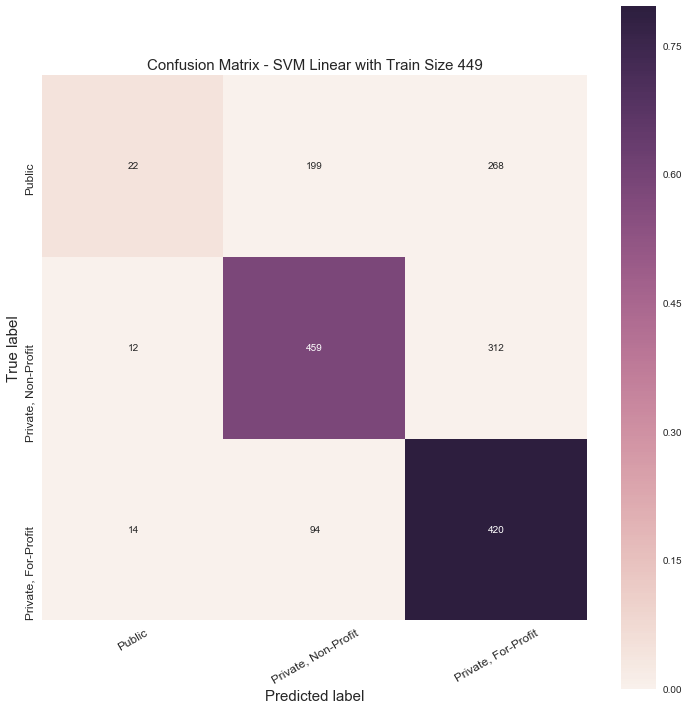

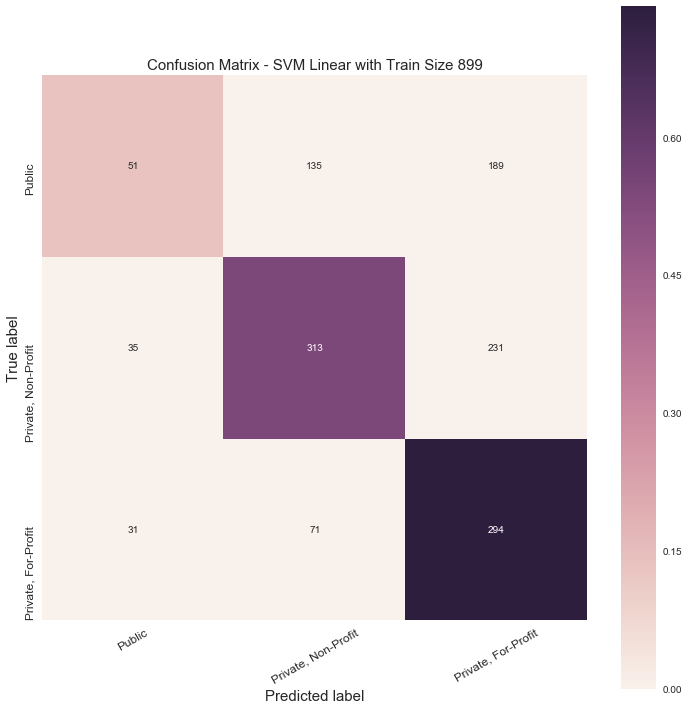

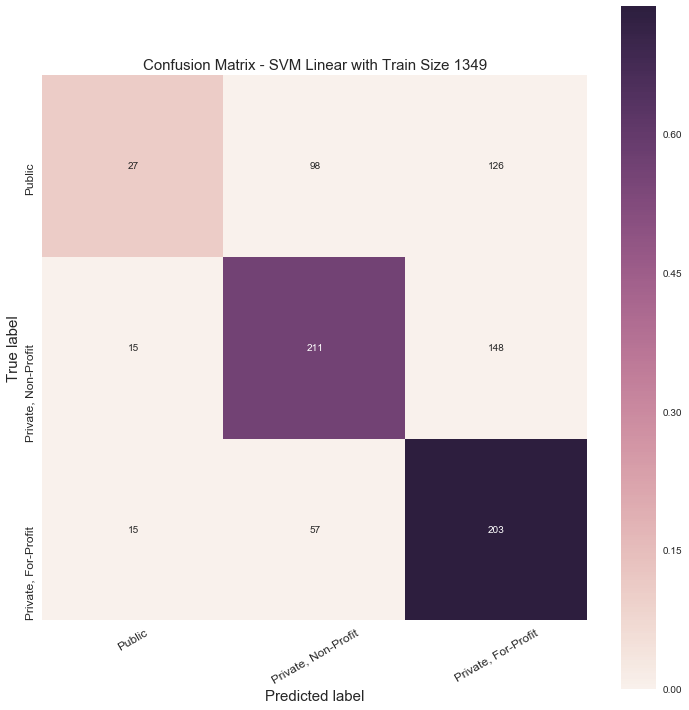

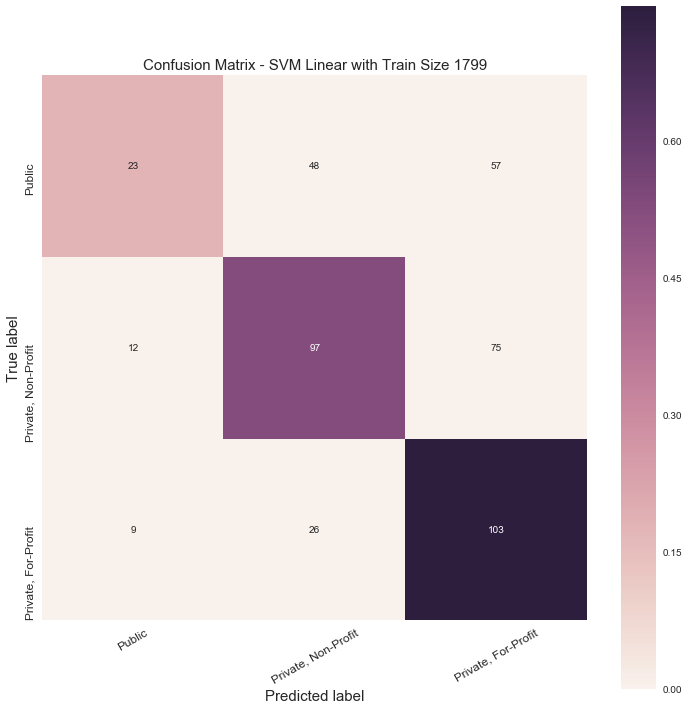

In [176]:
print "----------SVM Linear----------"

for i, n in enumerate([0.8, 0.6, 0.4, 0.2]):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 1 - n, random_state=3)
    ts, = Y_test.shape
    
    svm_linear = svm.SVC(kernel='linear')
    svm_linear.fit(X_train, Y_train)
    ypred_svm_linear = svm_linear.predict(X_test)
    e_svm_linear = sum(ypred_svm_linear != Y_test)
    insample_incorrect = sum(Y_train != svm_linear.predict(X_train)) / Y_train.shape[0] * 100
    print 'Insample misclassified = {0}%'.format(insample_incorrect)

    
    print 'For training size of {0}'.format(len(X_train))
    print e_svm_linear, "misclassified data out of", ts, "(", round(e_svm_linear/ts, 4) * 100,"%)"
    
    conf_m = confusion_matrix(Y_test, ypred_svm_linear)
    fig = pl.figure(figsize = (10, 10))
    plot_confusion_matrix(conf_m, classes = labels, 
                          title = 'Confusion Matrix - SVM Linear with Train Size {0}'.format(len(X_train)))
    pl.savefig('confusion_matrix_SVM_Linear_{0}.jpg'.format(str(len(X_train))))

# SVM - predict school type based on share of students taking loan and median debt for three income brackets

In [218]:
test_variables = ['CONTROL', 'LO_INC_DEBT_MDN', 'HI_INC_DEBT_MDN', 'MD_INC_DEBT_MDN', 'LOAN_EVER']

In [219]:
test2 = df_4yr_2010[test_variables]

In [234]:
test2 = test2.convert_objects(convert_numeric = 'coerce')
test2.dropna(inplace = True)

C:\Users\shibbie\Anaconda_2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [237]:
test2.describe()

,CONTROL,LO_INC_DEBT_MDN,HI_INC_DEBT_MDN,MD_INC_DEBT_MDN,LOAN_EVER
count,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000
mean,2.007809,10835.677148,11380.814838,11932.576860,0.894257
std,0.741412,4350.586423,3892.095864,4359.719014,0.108441
min,1.000000,1191.000000,2625.000000,2625.000000,0.139811
25%,1.000000,7241.000000,9000.000000,9206.000000,0.879401
50%,2.000000,10370.000000,11000.000000,11751.000000,0.928536
75%,3.000000,13750.000000,14077.000000,15000.000000,0.953063
max,3.000000,30124.000000,24031.000000,34012.500000,0.992834


In [238]:
test2.groupby('CONTROL').mean()

,LO_INC_DEBT_MDN,HI_INC_DEBT_MDN,MD_INC_DEBT_MDN,LOAN_EVER
CONTROL,,,,
1,10418.746586,10019.700303,10857.918058,0.845874
2,13123.678832,13254.053832,14254.295164,0.922188
3,7542.325221,9675.659292,9224.017699,0.896134


In [243]:
# percentages of each type. 1 = Public, 2 = Private Non-Profit, 3 = Private For-Profit
test2.groupby('CONTROL')['LOAN_EVER'].count() / len(test2)

CONTROL
1    0.270859
2    0.450473
3    0.278668
Name: LOAN_EVER, dtype: float64

In [244]:
X = test2[test2.columns[1:]]
Y = test2[test2.columns[0]]

Insample misclassified = 40.281855549%
For training size of 1703
288 misclassified data out of 730 ( 39.45 %)


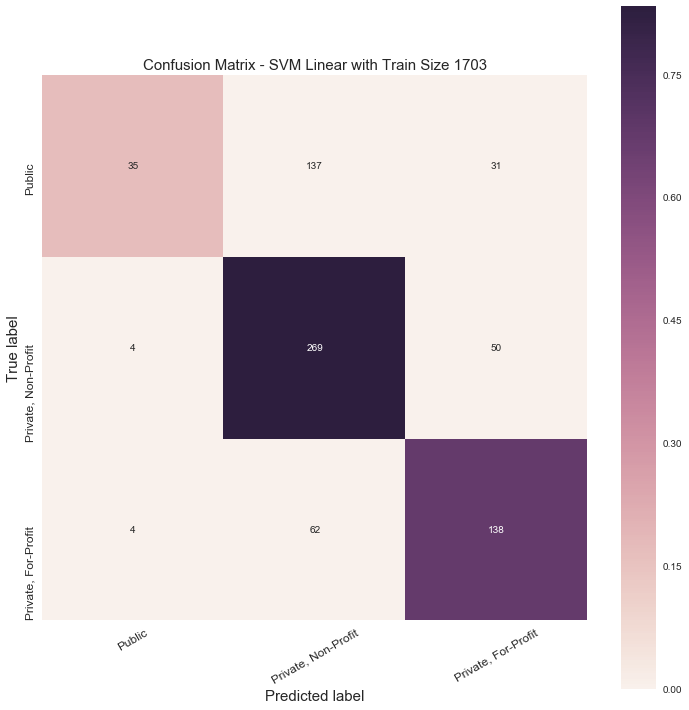

In [245]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = .7, random_state=3)
ts, = Y_test.shape

svm_linear = svm.SVC(kernel='linear')
svm_linear.fit(X_train, Y_train)
ypred_svm_linear = svm_linear.predict(X_test)
e_svm_linear = sum(ypred_svm_linear != Y_test)
insample_incorrect = sum(Y_train != svm_linear.predict(X_train)) / Y_train.shape[0] * 100
print 'Insample misclassified = {0}%'.format(insample_incorrect)


print 'For training size of {0}'.format(len(X_train))
print e_svm_linear, "misclassified data out of", ts, "(", round(e_svm_linear/ts, 4) * 100,"%)"

conf_m = confusion_matrix(Y_test, ypred_svm_linear)
fig = pl.figure(figsize = (10, 10))
plot_confusion_matrix(conf_m, classes = labels, 
                      title = 'Confusion Matrix - SVM Linear with Train Size {0}'.format(len(X_train)))
pl.savefig('confusion_matrix_SVM_Linear_{0}.jpg'.format(str(len(X_train))))